# Estimate generation v2

Use advanced models for generation estimation in the Global Power Plant Database.
Primary model is a two-hidden-layer neural network.

In [ ]:
# import what we'll need and set parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, Dropout, Activation, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pydot

GPPD_FILENAME = '../../output_database/global_power_plant_database.csv'
WEIGHTS_FILE = "model/estimate_generation.h5"
VALIDATION_FRACTION = 0.2


In [3]:
# read in database
df = pd.read_csv(GPPD_FILENAME)
df.head()


,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,fuel1,fuel2,fuel3,...,owner,source,url,geolocation_source,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,estimated_generation_gwh
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.00,32.3220,65.1190,Hydro,NaN,NaN,...,NaN,GEODB,http://globalenergyobservatory.org,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.00,34.5560,69.4787,Hydro,NaN,NaN,...,NaN,GEODB,http://globalenergyobservatory.org,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.00,34.6410,69.7170,Hydro,NaN,NaN,...,NaN,GEODB,http://globalenergyobservatory.org,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,Nangarhar (Darunta) Hydroelectric Power Plant ...,GEODB0040536,11.55,34.4847,70.3633,Hydro,NaN,NaN,...,NaN,GEODB,http://globalenergyobservatory.org,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,Northwest Kabul Power Plant Afghanistan,GEODB0040540,42.00,34.5638,69.1134,Gas,NaN,NaN,...,NaN,GEODB,http://globalenergyobservatory.org,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN


In [4]:
# show count for number of valid entries in each column
df.count()

country                     25657
country_long                25657
name                        25637
gppd_idnr                   25657
capacity_mw                 25657
latitude                    25657
longitude                   25657
fuel1                       25657
fuel2                        1670
fuel3                         295
fuel4                         107
commissioning_year          13933
owner                       17157
source                      25657
url                         25657
geolocation_source          25657
year_of_capacity_data       16065
generation_gwh_2013           371
generation_gwh_2014           386
generation_gwh_2015           887
generation_gwh_2016          8326
estimated_generation_gwh    24633
dtype: int64

In [5]:
# prepare data for training

# convert string-type columns to categories (assume no NaNs in these columns)
factorized_countries,country_key = df['country'].factorize()
df['country'] = factorized_countries
factorized_fuel1,fuel1_key = df['fuel1'].factorize()
df['fuel1'] = factorized_fuel1

# convert numerical columns to np array to use as predictor variables and remove NaNs
X_columns = ['country','capacity_mw','latitude','longitude','commissioning_year','fuel1']
df_No_NaN = df[X_columns + ['generation_gwh_2016']].dropna(how='any')
X_data = df_No_NaN[X_columns].as_matrix()

# calculate capacity factor to use as predicted variable
df_No_NaN['capacity_factor'] = df_No_NaN.apply(lambda row:row['generation_gwh_2016']/(24.0*365.0*0.001*row['capacity_mw']),axis=1)
y_column = ['capacity_factor']
y_data = df_No_NaN[y_column].as_matrix()

# show results
print(X_data)
print(y_data)
print(len(X_data))
print(len(y_data))

[[  8.00000000e+00   2.89000000e+02   4.72078000e+01   1.10057000e+01
    1.98100000e+03   0.00000000e+00]
 [  8.00000000e+00   5.00000000e+02   4.72696000e+01   1.09678000e+01
    1.98100000e+03   0.00000000e+00]
 [  4.30000000e+01   2.25000000e+03   3.02483000e+01   3.09471000e+01
    2.01400000e+03   1.00000000e+00]
 ..., 
 [  1.57000000e+02   2.80000000e+01   1.43611000e+01   1.08720300e+02
    2.01400000e+03   0.00000000e+00]
 [  1.57000000e+02   1.95000000e+01   1.21526000e+01   1.08378700e+02
    2.01000000e+03   0.00000000e+00]
 [  1.57000000e+02   3.00000000e+01   1.58600000e+01   1.07653800e+02
    2.00900000e+03   0.00000000e+00]]
[[ 0.04692255]
 [ 0.02934475]
 [ 0.00674784]
 ..., 
 [ 0.41992825]
 [ 0.46247512]
 [ 0.46689498]]
8238
8238


In [6]:
# calculate scaling values for input data

mean_vals = np.mean(X_data,axis=0)
range_vals = np.max(X_data,axis=0) - np.min(X_data,axis=0)

In [7]:
# set up neural network

INPUT_SHAPE = X_data[0].shape
print(u"Input shape is: {0}".format(INPUT_SHAPE))
DROPOUT_RATE = 0.15
DENSE_LAYER_SIZE = 128

def myNet():
    model = Sequential()
    model.add(Lambda(lambda x: x - mean_vals,input_shape = INPUT_SHAPE))   # placeholder for normalization
    model.add(Dense(DENSE_LAYER_SIZE,activation='relu'))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation='relu'))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation='relu'))
    model.add(Dense(1))
    return model
    
model = myNet()
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])
print("Model contains {0} parameters.".format(model.count_params()))
print(model.summary())

Input shape is: (6,)
Model contains 34049 parameters.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)       

In [12]:
# fit model

BATCH_SIZE = 64
NUM_EPOCHS = 256
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.001,patience=64)
check_point = ModelCheckpoint(WEIGHTS_FILE,monitor='val_loss',save_best_only=True,mode='max')
history_object = model.fit(x=X_data, y=y_data,
                           batch_size = BATCH_SIZE,
                           epochs = NUM_EPOCHS,
                           verbose = 1,
                           callbacks = [early_stop,check_point],
                           validation_split = VALIDATION_FRACTION)
                           
# reload model with best weights from training
model = myNet()
model.load_weights(WEIGHTS_FILE)
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])
print("Finished training; model reloaded with optimum weights.")
model.save(WEIGHTS_FILE)

Train on 6590 samples, validate on 1648 samples
Epoch 1/256
6590/6590 [==============================] - 1s 152us/step - loss: 0.8625 - mean_absolute_error: 0.3745 - val_loss: 0.1406 - val_mean_absolute_error: 0.2477
Epoch 2/256
6590/6590 [==============================] - 0s 70us/step - loss: 0.3787 - mean_absolute_error: 0.2864 - val_loss: 0.0891 - val_mean_absolute_error: 0.2236
Epoch 3/256
6590/6590 [==============================] - 0s 67us/step - loss: 0.1281 - mean_absolute_error: 0.2272 - val_loss: 0.0633 - val_mean_absolute_error: 0.1993
Epoch 4/256
6590/6590 [==============================] - 0s 68us/step - loss: 0.0785 - mean_absolute_error: 0.2045 - val_loss: 0.0635 - val_mean_absolute_error: 0.1980
Epoch 5/256
6590/6590 [==============================] - 0s 70us/step - loss: 0.0713 - mean_absolute_error: 0.2027 - val_loss: 0.0658 - val_mean_absolute_error: 0.2005
Epoch 6/256
6590/6590 [==============================] - 0s 69us/step - loss: 0.0772 - mean_absolute_error: 0.2

6590/6590 [==============================] - 0s 69us/step - loss: 0.0574 - mean_absolute_error: 0.1908 - val_loss: 0.0630 - val_mean_absolute_error: 0.1976
Epoch 50/256
6590/6590 [==============================] - 0s 68us/step - loss: 0.0577 - mean_absolute_error: 0.1915 - val_loss: 0.0622 - val_mean_absolute_error: 0.1976
Epoch 51/256
6590/6590 [==============================] - 0s 66us/step - loss: 0.0574 - mean_absolute_error: 0.1906 - val_loss: 0.0618 - val_mean_absolute_error: 0.1972
Epoch 52/256
6590/6590 [==============================] - 0s 71us/step - loss: 0.0578 - mean_absolute_error: 0.1915 - val_loss: 0.0625 - val_mean_absolute_error: 0.1969
Epoch 53/256
6590/6590 [==============================] - 0s 66us/step - loss: 0.0596 - mean_absolute_error: 0.1911 - val_loss: 0.0628 - val_mean_absolute_error: 0.1978
Epoch 54/256
6590/6590 [==============================] - 0s 67us/step - loss: 0.0574 - mean_absolute_error: 0.1911 - val_loss: 0.0621 - val_mean_absolute_error: 0.1971

6590/6590 [==============================] - 0s 75us/step - loss: 0.0432 - mean_absolute_error: 0.1571 - val_loss: 0.0413 - val_mean_absolute_error: 0.1463
Epoch 98/256
6590/6590 [==============================] - 0s 72us/step - loss: 0.0430 - mean_absolute_error: 0.1565 - val_loss: 0.0466 - val_mean_absolute_error: 0.1560
Epoch 99/256
6590/6590 [==============================] - 0s 67us/step - loss: 0.0434 - mean_absolute_error: 0.1563 - val_loss: 0.0427 - val_mean_absolute_error: 0.1519
Epoch 100/256
6590/6590 [==============================] - 0s 69us/step - loss: 0.0433 - mean_absolute_error: 0.1556 - val_loss: 0.0483 - val_mean_absolute_error: 0.1578
Epoch 101/256
6590/6590 [==============================] - 0s 74us/step - loss: 0.0428 - mean_absolute_error: 0.1542 - val_loss: 0.0477 - val_mean_absolute_error: 0.1570
Epoch 102/256
6590/6590 [==============================] - 0s 74us/step - loss: 0.0421 - mean_absolute_error: 0.1534 - val_loss: 0.0425 - val_mean_absolute_error: 0.1

6590/6590 [==============================] - 0s 74us/step - loss: 0.0401 - mean_absolute_error: 0.1472 - val_loss: 0.0403 - val_mean_absolute_error: 0.1409
Epoch 146/256
6590/6590 [==============================] - 0s 71us/step - loss: 0.0403 - mean_absolute_error: 0.1480 - val_loss: 0.0499 - val_mean_absolute_error: 0.1564
Epoch 147/256
6590/6590 [==============================] - 0s 72us/step - loss: 0.0402 - mean_absolute_error: 0.1470 - val_loss: 0.0458 - val_mean_absolute_error: 0.1502
Epoch 148/256
6590/6590 [==============================] - 0s 72us/step - loss: 0.0396 - mean_absolute_error: 0.1458 - val_loss: 0.0433 - val_mean_absolute_error: 0.1464
Epoch 149/256
6590/6590 [==============================] - 0s 72us/step - loss: 0.0399 - mean_absolute_error: 0.1466 - val_loss: 0.0405 - val_mean_absolute_error: 0.1388
Epoch 150/256
6590/6590 [==============================] - 0s 70us/step - loss: 0.0400 - mean_absolute_error: 0.1467 - val_loss: 0.0439 - val_mean_absolute_error: 0

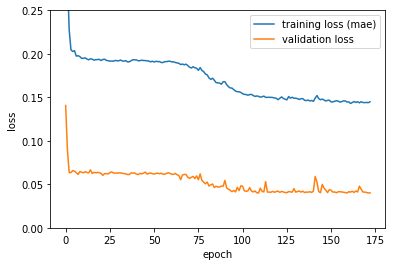

In [15]:
# plot training loss history
    
plt.plot(history_object.history['mean_absolute_error'])
plt.plot(history_object.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss (mae)','validation loss'],loc='upper right')
plt.ylim([0,0.25])
plt.show()

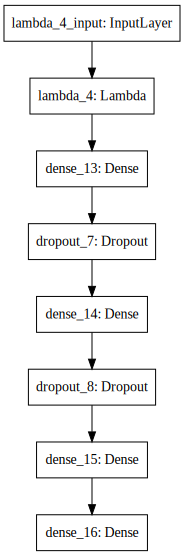

In [16]:
# visualize model

SVG(model_to_dot(model).create(prog='dot',format='svg'))